Dataset loaded successfully!

--- Dataset Overview ---
Dataset Shape: (535178, 10)

Dataset Description:
                step         amount          fraud
count  535178.000000  535178.000000  535178.000000
mean       94.982225      37.945166       0.012131
std        51.056459     112.585244       0.109469
min         0.000000       0.000000       0.000000
25%        52.000000      13.730000       0.000000
50%        97.000000      26.900000       0.000000
75%       139.000000      42.570000       0.000000
max       179.000000    8329.960000       1.000000

Missing Values (per column):
step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

Fraud Rate (%): 1.213054348272911

Duplicate Rows (count): 0

Shape after removing duplicates: (535178, 10)

--- Exploratory Data Analysis (EDA) ---

Fraud Cases: 6492
Valid Cases: 528686
Fraudulent transactions are: 1.228

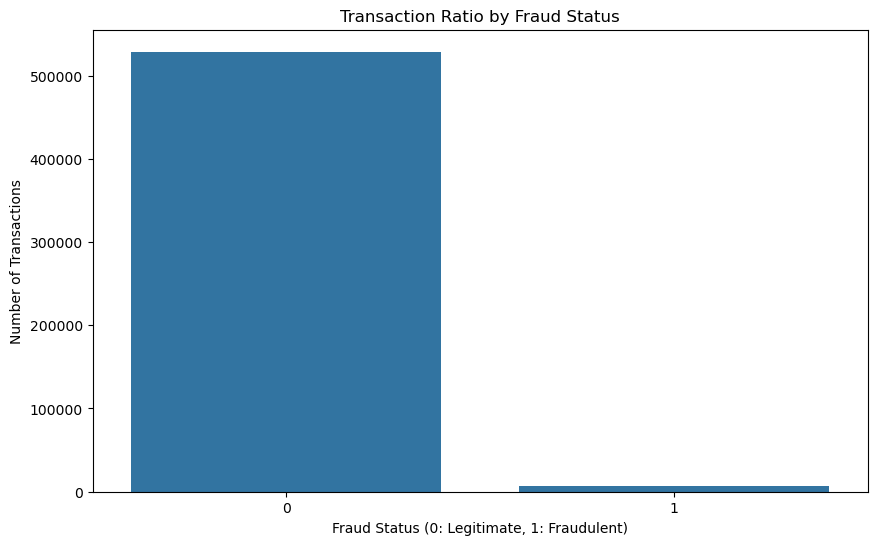

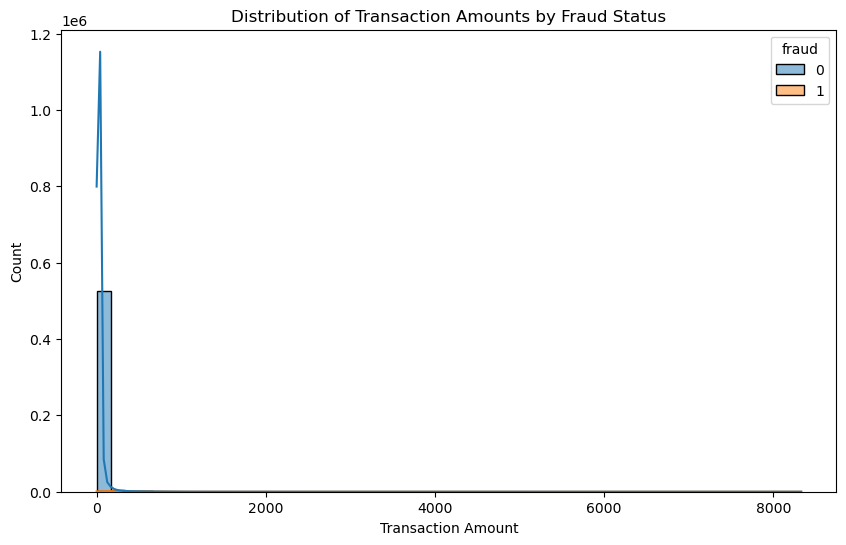

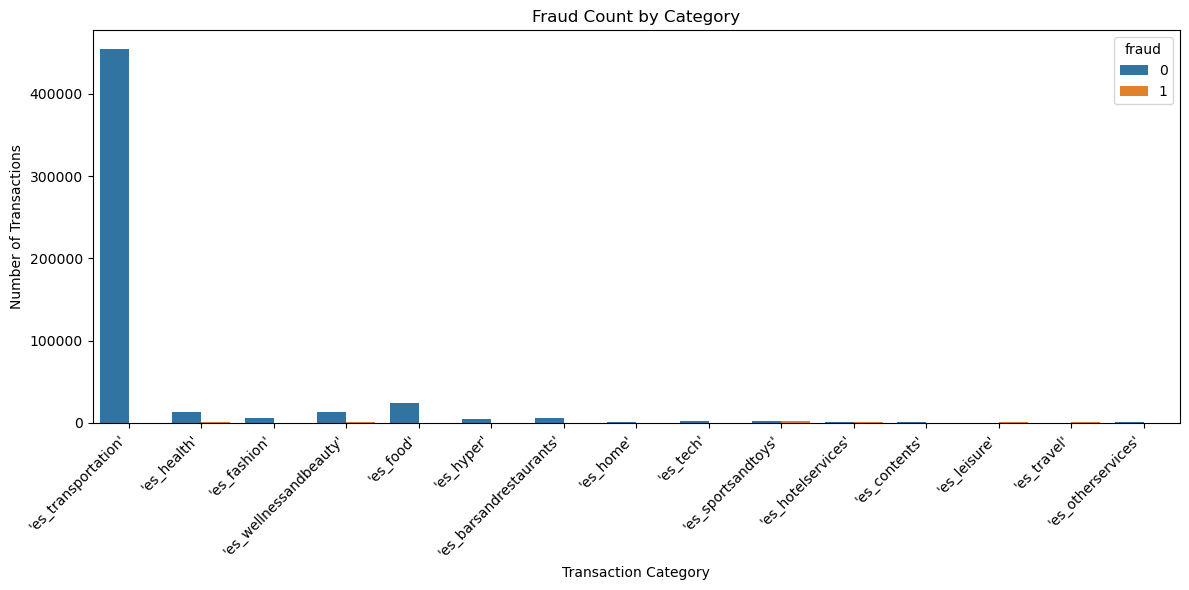

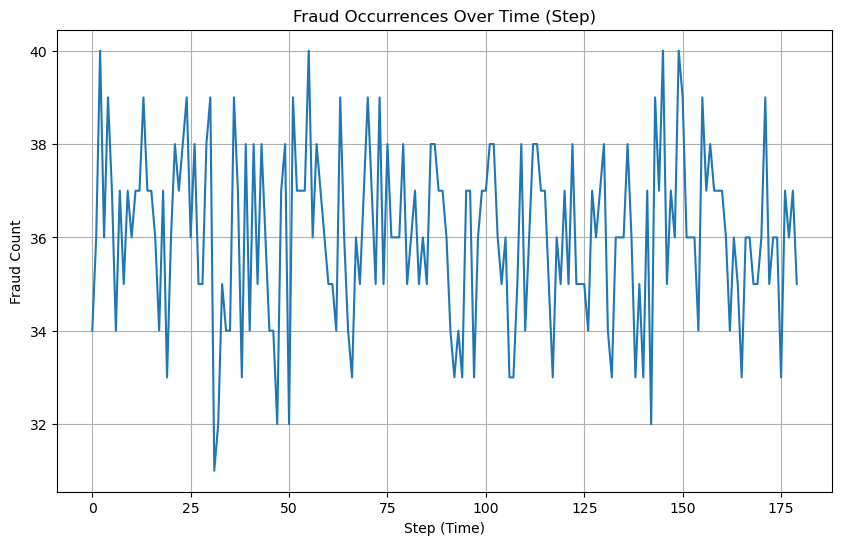

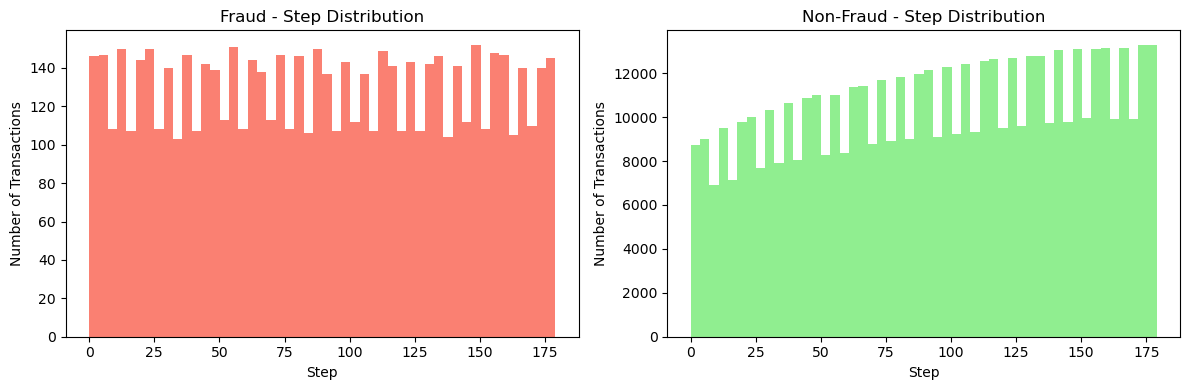

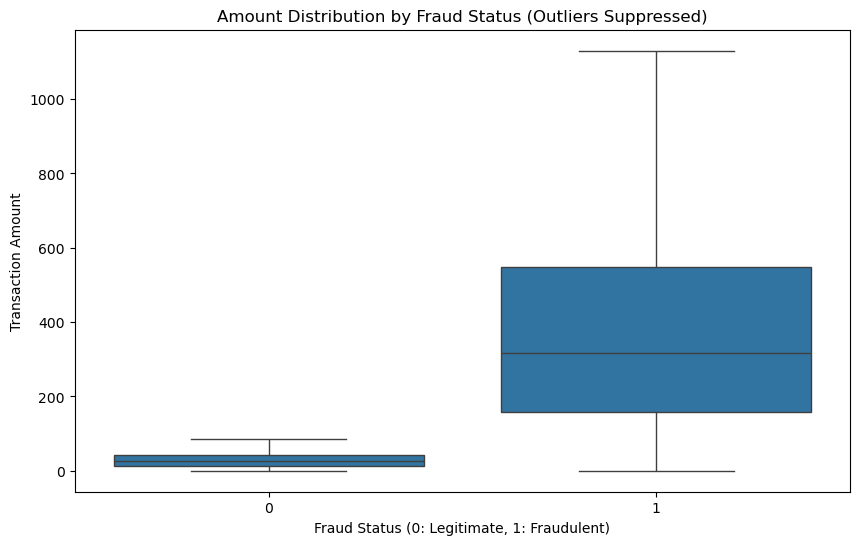

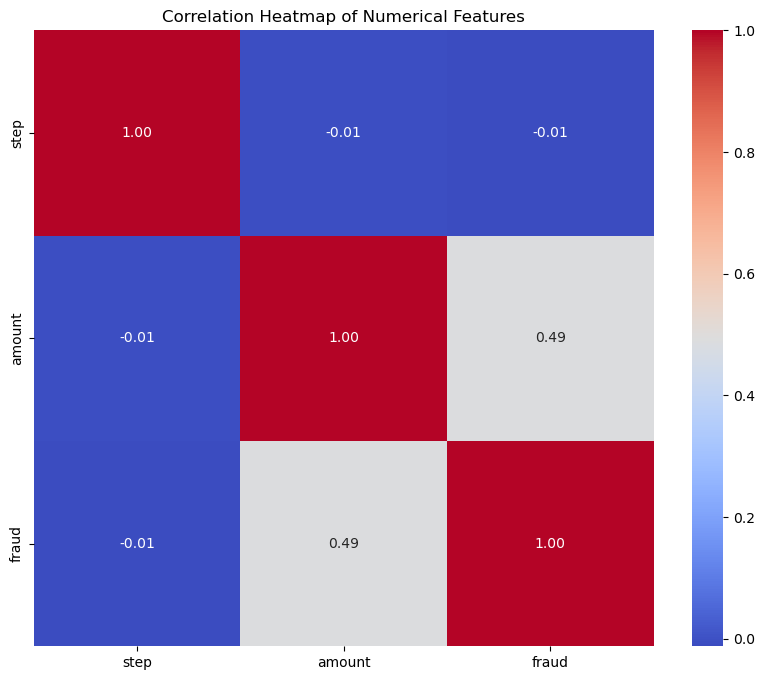


--- Data Preprocessing & Feature Engineering ---

No missing values found in the dataset.
Created 'step_hour' feature.
Created 'transaction_velocity' feature.
Created 'avg_customer_amount', 'avg_merchant_amount', 'transaction_count_customer' features.
Created 'amount_ratio' feature.
Created 'amount_deviation' feature.
Created 'same_zip' feature.
Applied Target Encoding to 'customer', 'merchant', 'category', 'gender', 'zipcodeOri', 'zipMerchant'.
Features (X) shape: (535178, 17), Target (y) shape: (535178,)
Applied StandardScaler to numerical features.


In [ ]:
# Fraud Detection Project: Real-time, Innovative Anomaly Detection
# This code implements the core concepts and algorithms discussed in the pitch.

# Phase 1: Data Acquisition & Understanding

# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import category_encoders as ce
import shap # For explainability
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Read Data into a Dataframe
# Assumes 'Dataset.csv' is available in the environment.
try:
    df = pd.read_csv('dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Dataset.csv not found. Please ensure the file is in the correct directory.")
    # Exit the script if the dataset is not found, as it's critical for the project.
    exit()

# --- Phase 1.1: Data Understanding ---
# Provides an initial overview of the dataset.
print("\n--- Dataset Overview ---")
print("Dataset Shape:", df.shape)
print("\nDataset Description:")
print(df.describe())
print("\nMissing Values (per column):")
print(df.isnull().sum())
print("\nFraud Rate (%):", df['fraud'].mean() * 100)
print("\nDuplicate Rows (count):", df.duplicated(keep=False).sum())

# Remove duplicates to ensure data quality.
df = df.drop_duplicates()
print("\nShape after removing duplicates:", df.shape)

# --- Phase 1.2: Exploratory Data Analysis (EDA) ---
# This section visualizes key aspects of the data to gain insights into fraud patterns.
print("\n--- Exploratory Data Analysis (EDA) ---")

# Separate fraudulent and legitimate transactions for comparison.
fraud = df[df.fraud == 1]
valid = df[df.fraud == 0]
outlier_percentage = (len(fraud) / len(valid)) * 100

print("\nFraud Cases:", len(fraud))
print("Valid Cases:", len(valid))
print("Fraudulent transactions are: %.3f%% of valid transactions" % outlier_percentage)
print("\nCompare the mean values for both transaction types (fraud vs. non-fraud):")
print(df.groupby('fraud').mean(numeric_only=True))

# Visualization 1: Transaction Ratio by Fraud Status
plt.figure(figsize=(10, 6))
sns.countplot(x='fraud', data=df)
plt.title('Transaction Ratio by Fraud Status')
plt.xlabel('Fraud Status (0: Legitimate, 1: Fraudulent)')
plt.ylabel('Number of Transactions')
plt.show()

# Visualization 2: Distribution of Transaction Amounts by Fraud Status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='fraud', multiple='stack', bins=50, kde=True)
plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

# Visualization 3: Fraud Count by Category
plt.figure(figsize=(12, 6))
sns.countplot(x='category', hue='fraud', data=df)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.title('Fraud Count by Category')
plt.xlabel('Transaction Category')
plt.ylabel('Number of Transactions')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Visualization 4: Fraud Occurrences Over Time (Step)
plt.figure(figsize=(10, 6))
fraud_over_step = df.groupby('step')['fraud'].sum()
plt.plot(fraud_over_step)
plt.xlabel('Step (Time)')
plt.ylabel('Fraud Count')
plt.title('Fraud Occurrences Over Time (Step)')
plt.grid(True)
plt.show()

# Visualization 5: Step Distribution for Fraud vs. Non-Fraud
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(fraud['step'], bins=50, color='salmon')
plt.title('Fraud - Step Distribution')
plt.xlabel('Step')
plt.ylabel('Number of Transactions')
plt.subplot(1, 2, 2)
plt.hist(valid['step'], bins=50, color='lightgreen')
plt.title('Non-Fraud - Step Distribution')
plt.xlabel('Step')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

# Visualization 6: Boxplot of Amount by Fraud Status (excluding extreme outliers for clarity)
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraud', y='amount', data=df, showfliers=False) # showfliers=False hides extreme outliers
plt.title('Amount Distribution by Fraud Status (Outliers Suppressed)')
plt.xlabel('Fraud Status (0: Legitimate, 1: Fraudulent)')
plt.ylabel('Transaction Amount')
plt.show()

# Visualization 7: Correlation Heatmap of Numerical Features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# --- Phase 2: Data Preprocessing & Feature Engineering ---
# This phase prepares the data for machine learning models, creating new features
# and transforming existing ones for better model performance.

print("\n--- Data Preprocessing & Feature Engineering ---")

# 2.1 Data Cleaning
# Handle missing values. Assuming 'amount' and 'category' might have missing values.
if df.isnull().sum().sum() > 0:
    df['amount'].fillna(df['amount'].median(), inplace=True)
    df['category'].fillna(df['category'].mode()[0], inplace=True)
    print("\nMissing values handled: 'amount' filled with median, 'category' with mode.")
else:
    print("\nNo missing values found in the dataset.")

# 2.2 Feature Engineering - Creating rich, behavioral features
# These features are crucial for capturing subtle fraud patterns.

# Time-based features
df['step_hour'] = df['step'] % 24  # Hour of the day based on 'step'
print("Created 'step_hour' feature.")

# Transaction velocity (time difference between consecutive transactions for each customer)
# fillna(1) handles the first transaction for each customer.
df['transaction_velocity'] = df.groupby('customer')['step'].transform(lambda x: x.diff().fillna(1))
print("Created 'transaction_velocity' feature.")

# Aggregated features (customer and merchant specific averages/counts)
df['avg_customer_amount'] = df.groupby('customer')['amount'].transform('mean')
df['avg_merchant_amount'] = df.groupby('merchant')['amount'].transform('mean')
df['transaction_count_customer'] = df.groupby('customer')['amount'].transform('count')
print("Created 'avg_customer_amount', 'avg_merchant_amount', 'transaction_count_customer' features.")

# Ratio features (current amount relative to customer's average)
df['amount_ratio'] = df['amount'] / df['avg_customer_amount']
print("Created 'amount_ratio' feature.")

# Behavioral features (deviation from customer's average amount)
df['amount_deviation'] = df['amount'] - df['avg_customer_amount']
print("Created 'amount_deviation' feature.")

# Geospatial feature (simplified: check if customer and merchant zip codes are the same)
df['same_zip'] = (df['zipcodeOri'] == df['zipMerchant']).astype(int)
print("Created 'same_zip' feature.")

# Categorical Encoding using TargetEncoder for high-cardinality features
# TargetEncoder is chosen for 'customer', 'merchant', and 'category' to capture their relationship with 'fraud'.
encoder = ce.TargetEncoder(cols=['customer', 'merchant', 'category', 'gender', 'zipcodeOri', 'zipMerchant'])
# Fit and transform the entire dataframe for consistent encoding.
df_encoded = encoder.fit_transform(df, df['fraud'])
print("Applied Target Encoding to 'customer', 'merchant', 'category', 'gender', 'zipcodeOri', 'zipMerchant'.")

# Prepare features (X) and target (y) for modeling
X = df_encoded.drop(['fraud'], axis=1)
y = df_encoded['fraud']
print(f"Features (X) shape: {X.shape}, Target (y) shape: {y.shape}")

# 2.3 Data Scaling - Standardizing numerical features
# StandardScaler is used to normalize numerical features, preventing features with larger ranges
# from dominating the learning process.
scaler = StandardScaler()
# Define all numerical columns, including the newly engineered ones.
numerical_cols = ['step', 'amount', 'transaction_velocity', 'avg_customer_amount',
                  'avg_merchant_amount', 'transaction_count_customer',
                  'amount_ratio', 'amount_deviation', 'step_hour']
# Apply scaling only to the numerical columns.
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
print("Applied StandardScaler to numerical features.")

# --- FIX for ValueError: could not convert string to float ---
# Ensure all columns in X are numeric before applying PowerTransformer.
# This step converts any remaining non-numeric columns to numeric, coercing errors to NaN.
# Then, fill any NaNs that result from this conversion (e.g., with 0 or a mean/median).
for col in X.columns:
    if X[col].dtype == 'object':
        # Attempt to convert to numeric, coercing errors will turn problematic strings into NaN
        X[col] = pd.to_numeric(X[col], errors='coerce')
        # Fill any NaNs that resulted from the coercion. Using 0 as a simple fallback.
        # A more sophisticated approach might use the column's mean/median.
        if X[col].isnull().any():
            X[col].fillna(0, inplace=True)
            print(f"Warning: Converted non-numeric values in '{col}' to NaN and filled with 0.")

# Handle skewness with PowerTransformer
# PowerTransformer applies a power transform to make data more Gaussian-like, which can
# improve model performance for some algorithms.
pt = PowerTransformer(method='yeo-johnson', standardize=True)
# Apply PowerTransformer to all features after numerical scaling and encoding.
# This ensures consistency for all features that might benefit from it.
X[X.columns] = pt.fit_transform(X)
print("Applied PowerTransformer to all features.")

# 2.4 Handling Imbalance with SMOTE (Synthetic Minority Over-sampling Technique)
# SMOTE is used to address the class imbalance by creating synthetic samples of the minority class (fraud).
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(f"\nShape after SMOTE (resampled features): {X_res.shape}")
print(f"Class distribution after SMOTE:\n{y_res.value_counts()}")

# --- Phase 3: Model Selection & Training ---
# This phase involves splitting the data, training various ML models, and evaluating their performance.

print("\n--- Model Selection & Training ---")

# Split data into training and testing sets.
# Stratify ensures that the proportion of fraud cases is maintained in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8, test_size=0.2, random_state=42, stratify=y_res)
print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Define a function to evaluate and visualize model performance.
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, dataset_type):
    """
    Evaluates and visualizes the performance of a classification model.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        y_pred_proba (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model.
        dataset_type (str): Type of dataset (e.g., "Training", "Testing").
    """
    print(f"\n--- {model_name} - {dataset_type} Set Evaluation ---")
    print(f"Recall score: {recall_score(y_true, y_pred):.4f}")
    print(f"Precision score: {precision_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"Accuracy score: {accuracy_score(y_true, y_pred):.4f}")
    print(f"AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(f'{model_name} - {dataset_type} Set Confusion Matrix (Accuracy: {accuracy_score(y_true, y_pred):.4f})')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.show()

    # ROC Curve Visualization
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=f'{model_name} - AUC={roc_auc_score(y_true, y_pred_proba):.3f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(f'ROC Curve for {model_name} - {dataset_type} Set')
    plt.grid(True)
    plt.show()

# Define the machine learning models to be trained and evaluated.
# These models represent a mix of foundational and advanced algorithms for fraud detection.
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    # Add other models like Isolation Forest, One-Class SVM here if desired
    # "Isolation Forest": IsolationForest(random_state=42), # Note: Isolation Forest is unsupervised, needs different evaluation
    # "One-Class SVM": OneClassSVM(gamma='auto') # Also unsupervised, needs different evaluation
}

results = [] # To store evaluation results for comparison
for name, model in models.items():
    print(f"\n--- Training {name} Model ---")
    model.fit(X_train, y_train) # Train the model on the training data

    # Make predictions and predict probabilities for evaluation
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate model on both training and testing sets
    evaluate_model(y_train, y_train_pred, y_train_proba, name, "Training")
    evaluate_model(y_test, y_test_pred, y_test_proba, name, "Testing")

    # Store key metrics for overall comparison
    results.append({
        'Model': name,
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Test Precision': precision_score(y_test, y_test_pred),
        'Test Recall': recall_score(y_test, y_test_pred),
        'Test F1': f1_score(y_test, y_test_pred),
        'Test AUC': roc_auc_score(y_test, y_test_proba)
    })

# Compare models based on key test set metrics.
results_df = pd.DataFrame(results)
print("\n--- Model Comparison on Test Set ---")
print(results_df.sort_values(by='Test F1', ascending=False)) # Sort by F1-Score

# Visualization of Model Accuracy Comparison
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Test Accuracy', data=results_df, palette='viridis')
plt.title('Accuracy of Different Models on Test Set')
plt.ylabel('Accuracy')
for i, row in results_df.iterrows():
    plt.text(i, row['Test Accuracy'], f"{row['Test Accuracy']:.2%}", ha='center', va='bottom')
plt.show()

# ROC Curve Comparison for all models
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill') # Baseline for ROC curve
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Across Models')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- Phase 4: Evaluation & Optimization ---
# This phase focuses on understanding model predictions and considering robustness.

# Feature Importance (using SHAP for XGBoost as it's a strong candidate model)
xgb_model = models['XGBoost'] # Assuming XGBoost is chosen as the best model for this section.
print("\n--- Feature Importance (SHAP) for XGBoost ---")

# SHAP values can be computationally intensive for very large datasets.
# Using a subset of X_test for SHAP explanation can be faster for demonstration.
# For full accuracy, use the entire X_test.
# shap_sample = X_test.sample(n=min(5000, len(X_test)), random_state=42) if len(X_test) > 5000 else X_test
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test) # Using the full X_test for comprehensive analysis

plt.figure(figsize=(12, 8))
# Summary plot for overall feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Overall Feature Importance (SHAP) for XGBoost Model')
plt.tight_layout()
plt.show()

# SHAP dependence plots can show how individual features affect the prediction.
# Example for a specific feature (e.g., 'amount')
# if 'amount' in X_test.columns:
#     plt.figure(figsize=(10, 6))
#     shap.dependence_plot("amount", shap_values, X_test, interaction_index=None, show=False)
#     plt.title('SHAP Dependence Plot for Amount')
#     plt.tight_layout()
#     plt.show()


# --- Phase 5: Real-time Deployment Considerations (Conceptual) ---
# This section outlines the conceptual architecture for deploying the model in a real-time environment.
print("\n--- Real-time Deployment Architecture (Conceptual) ---")
print("To deploy this AI-Powered Fraud Detection System in real-time, consider the following architecture:")
print("1.  **Data Ingestion Layer:** Utilize a high-throughput streaming platform like **Apache Kafka** to ingest raw transaction data as it occurs. This ensures low-latency data availability.")
print("2.  **Feature Store:** A critical component for real-time feature computation and lookup. This store (e.g., **Redis**, Feast) would pre-compute and store aggregate and behavioral features (like `avg_customer_amount`, `transaction_velocity`) in real-time or near real-time. This allows the prediction service to quickly retrieve necessary historical context for new transactions.")
print("3.  **Prediction Service (Model API):** The trained machine learning model (e.g., the best-performing XGBoost model) would be deployed as a lightweight, low-latency **microservice** with a RESTful API (e.g., using **Flask** or **FastAPI**). This service would:")
print("    * Receive new transaction data.")
print("    * Query the Feature Store for relevant pre-computed features.")
print("    * Perform necessary real-time feature engineering (e.g., `step_hour`, `same_zip`).")
print("    * Apply the *fitted* `encoder`, `scaler`, and `PowerTransformer` to preprocess the incoming transaction data consistently with training data.")
print("    * Make a fraud prediction (binary classification and probability score).")
print("4.  **Alerting & Action System:** Based on the model's prediction and probability score, an automated system would:")
print("    * Trigger immediate alerts to a fraud investigation team for review.")
print("    * Potentially initiate automated actions like transaction blocking or flagging for manual review, based on predefined risk thresholds.")
print("5.  **Monitoring & Feedback Loop:** Continuous monitoring of model performance (precision, recall, AUC) in a production environment is crucial. A feedback loop should be established to retrain the model with new data and adapt to evolving fraud patterns (e.g., MLOps pipeline).")
print("6.  **Model Efficiency & Scalability:** The chosen models (like XGBoost) are generally efficient. Further optimizations (e.g., model quantization, pruning) can be explored for extremely high-volume scenarios. The microservice architecture allows for horizontal scaling.")
print("7.  **Explainability Integration:** Integrate SHAP or LIME directly into the prediction service to provide real-time explanations for flagged transactions, enhancing trust and empowering human operators.")


# --- Phase 6: Prediction CSV Generation ---
# Generates predictions on the test set (from SMOTE-resampled data) for evaluation purposes.
# This CSV is typically part of the submission guidelines to show model performance on unseen data.
print("\n--- Generating Predictions for Test Set ---")
test_predictions = xgb_model.predict(X_test)
test_prediction_probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Create a DataFrame for test set predictions
prediction_df = pd.DataFrame({
    'Original_Index_From_Resampled_Data': X_test.index, # Index from the resampled X_test
    'Fraud_Prediction': test_predictions,
    'Fraud_Probability': test_prediction_probabilities
})
prediction_df.to_csv('predictions.csv', index=False)
print("Predictions for the test set saved to 'predictions.csv'")
print(f"Shape of test set predictions: {prediction_df.shape}")
print("First 5 rows of test set predictions:")
print(prediction_df.head())


# --- Generating Predictions for the Entire Preprocessed Dataset (X) ---
# This section applies the best trained model (XGBoost) to the entire dataset (X)
# after all preprocessing steps (encoding, scaling, power transformation) but *before* SMOTE.
# This provides predictions for all original rows in the dataset, which can be useful for
# a comprehensive overview or for a final submission file covering the entire dataset.
print("\n--- Generating Predictions for the Entire Preprocessed Dataset (X) ---")

# Predict fraud status for all rows in X (the preprocessed original dataset)
full_dataset_predictions = xgb_model.predict(X)
full_dataset_probabilities = xgb_model.predict_proba(X)[:, 1]

# Create a DataFrame to store these predictions
# We use df.index to ensure we maintain the original row indices from the raw dataset.
full_predictions_df = pd.DataFrame({
    'Original_Dataset_Index': df.index,
    'Fraud_Prediction': full_dataset_predictions,
    'Fraud_Probability': full_dataset_probabilities
})

# Save the full dataset predictions to a new CSV file
full_predictions_df.to_csv('full_dataset_predictions.csv', index=False)
print("Predictions for the entire preprocessed dataset saved to 'full_dataset_predictions.csv'")
print(f"Shape of full dataset predictions: {full_predictions_df.shape}")
print("First 5 rows of full dataset predictions:")
print(full_predictions_df.head())


# --- Manual Transaction Verification (Simulating Real-time Prediction for a Single Transaction) ---
# This function demonstrates how a single, new transaction would be processed and predicted
# by the deployed model.
# IMPORTANT: In a real-time system, aggregate features (like transaction_velocity, avg_customer_amount)
# would be looked up from a feature store based on the 'customer' and 'merchant' IDs.
# For this example, we assume these values are provided in the input dictionary.
def predict_transaction(features_dict, model, encoder_obj, scaler_obj, pt_obj, numerical_cols_list, X_train_cols):
    """
    Predicts fraud for a single transaction dictionary.

    Args:
        features_dict (dict): A dictionary containing raw features for a single transaction.
        model: The trained machine learning model.
        encoder_obj: The fitted TargetEncoder object.
        scaler_obj: The fitted StandardScaler object.
        pt_obj: The fitted PowerTransformer object.
        numerical_cols_list (list): List of numerical column names.
        X_train_cols (list): List of column names from the training features (X.columns).

    Returns:
        tuple: A tuple containing the predicted status ('Fraudulent'/'Legitimate')
               and the probability of fraud.
    """
    # Create a DataFrame from the input dictionary for consistency.
    input_df = pd.DataFrame([features_dict])

    # Ensure the input DataFrame has all columns that were present in the training data (X).
    # This is crucial for consistent transformation by the fitted encoder, scaler, and power transformer.
    # Create a dummy DataFrame with all expected columns from X_train_cols for alignment.
    aligned_input_df = pd.DataFrame(columns=X_train_cols)
    for col in input_df.columns:
        if col in aligned_input_df.columns:
            aligned_input_df[col] = input_df[col]

    # Fill any missing columns in the aligned_input_df with sensible defaults.
    # For categorical columns, use a placeholder like 'UNKNOWN' so the encoder can handle it.
    # For numerical columns, use 0 or a global mean/median if a more sophisticated fallback is needed.
    for col in aligned_input_df.columns:
        if col not in input_df.columns:
            if col in encoder_obj.cols: # Check if it's one of the columns the encoder expects
                aligned_input_df[col] = 'UNKNOWN_PLACEHOLDER'
            elif col in numerical_cols_list:
                aligned_input_df[col] = 0.0 # Default numerical value
            else:
                aligned_input_df[col] = 0 # Other columns

    input_df = aligned_input_df.copy() # Use the aligned DataFrame for feature engineering

    # --- Feature Engineering for the single transaction (consistent with training) ---
    input_df['step_hour'] = input_df['step'] % 24
    input_df['same_zip'] = (input_df['zipcodeOri'] == input_df['zipMerchant']).astype(int)

    # Handle aggregate features. In a real-time system, these would be looked up from a feature store.
    # For this example, we assume they are provided in features_dict or use a fallback.
    # Fallback to global means/defaults if not provided (less accurate but prevents errors).
    if 'avg_customer_amount' not in input_df.columns or pd.isna(input_df['avg_customer_amount'].iloc[0]):
        input_df['avg_customer_amount'] = df['amount'].mean()
        print("Warning: 'avg_customer_amount' not provided for single transaction. Using global mean.")
    if 'avg_merchant_amount' not in input_df.columns or pd.isna(input_df['avg_merchant_amount'].iloc[0]):
        input_df['avg_merchant_amount'] = df['amount'].mean()
        print("Warning: 'avg_merchant_amount' not provided for single transaction. Using global mean.")
    if 'transaction_count_customer' not in input_df.columns or pd.isna(input_df['transaction_count_customer'].iloc[0]):
        input_df['transaction_count_customer'] = 1 # Default to 1 for new customers
        print("Warning: 'transaction_count_customer' not provided for single transaction. Using 1.")
    if 'transaction_velocity' not in input_df.columns or pd.isna(input_df['transaction_velocity'].iloc[0]):
        input_df['transaction_velocity'] = 1.0 # Default velocity
        print("Warning: 'transaction_velocity' not provided for single transaction. Using 1.0.")

    input_df['amount_ratio'] = input_df['amount'] / input_df['avg_customer_amount']
    input_df['amount_deviation'] = input_df['amount'] - input_df['avg_customer_amount']

    # Select and order columns exactly as they were in the training features (X).
    # This is critical for applying the fitted transformers correctly.
    input_processed = input_df[X_train_cols].copy()

    # Apply the *fitted* encoder to the single transaction.
    input_encoded = encoder_obj.transform(input_processed)

    # Apply the *fitted* scaler to numerical features.
    input_encoded[numerical_cols_list] = scaler_obj.transform(input_encoded[numerical_cols_list])

    # Apply the *fitted* power transformer.
    input_transformed = pt_obj.transform(input_encoded)

    # Make prediction
    prediction = model.predict(input_transformed)
    prediction_proba = model.predict_proba(input_transformed)[:, 1]

    status = "Fraudulent" if prediction[0] == 1 else "Legitimate"
    return status, prediction_proba[0]

# Example usage for manual verification
# IMPORTANT: For a realistic single transaction prediction, you would need to provide
# the pre-computed aggregate features like avg_customer_amount, transaction_velocity, etc.
# These would typically come from a real-time feature store in a deployed system.
example_transaction = {
    'step': 100,
    'customer': 'C123456789', # Example customer ID
    'age': 30,
    'gender': 'M',
    'zipcodeOri': '28007',
    'merchant': 'M987654321', # Example merchant ID
    'zipMerchant': '28007',
    'category': 'es_transportation',
    'amount': 500.00,
    # --- These values would typically come from a real-time feature store ---
    'transaction_velocity': 1.5, # Avg time between transactions for this customer
    'avg_customer_amount': 150.0, # Avg transaction amount for this customer
    'avg_merchant_amount': 200.0, # Avg transaction amount for this merchant
    'transaction_count_customer': 10 # Number of transactions for this customer
}

print("\n--- Manual Transaction Verification Example ---")
# Use the best performing model (e.g., XGBoost) for the example.
best_model = models['XGBoost']
predicted_status, predicted_proba = predict_transaction(
    example_transaction, best_model, encoder, scaler, pt, numerical_cols, X.columns
)
print(f"The example transaction is predicted as: {predicted_status} (Probability of Fraud: {predicted_proba:.4f})")



In [ ]:
!pip install category_encoders
!pip install imbalanced-learn
!pip install shap # If not already installed

In [ ]:
# Phase 7: Save Model and Preprocessing Objects ---
import joblib

print("\n--- Saving Model and Preprocessing Objects ---")

# Define the objects to save
best_model = models['XGBoost'] # Assuming XGBoost is the best model
artifacts = {
    'model': best_model,
    'encoder': encoder,
    'scaler': scaler,
    'power_transformer': pt,
    'numerical_cols': numerical_cols,
    'feature_names': X.columns.tolist() # Save the exact order of columns
}

# Save each artifact to a file
for name, obj in artifacts.items():
    joblib.dump(obj, f'{name}.joblib')
    print(f"Saved {name} to {name}.joblib")

In [ ]:
# --- Full Testing Script ---

#1. Import necessary libraries for testing
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 2. Define the prediction and evaluation functions
def preprocess_and_predict(df_test, artifacts):
    """Applies the full preprocessing pipeline to new data and returns predictions."""
    print("--- Starting Preprocessing and Prediction ---")
    
    model = artifacts['model']
    encoder = artifacts['encoder']
    scaler = artifacts['scaler']
    pt = artifacts['power_transformer']
    numerical_cols = artifacts['numerical_cols']
    feature_names = artifacts['feature_names']

    print("Performing feature engineering...")
    df_test['step_hour'] = df_test['step'] % 24
    df_test['transaction_velocity'] = df_test.groupby('customer')['step'].transform(lambda x: x.diff().fillna(1))
    df_test['avg_customer_amount'] = df_test.groupby('customer')['amount'].transform('mean')
    df_test['avg_merchant_amount'] = df_test.groupby('merchant')['amount'].transform('mean')
    df_test['transaction_count_customer'] = df_test.groupby('customer')['amount'].transform('count')
    df_test['amount_ratio'] = df_test['amount'] / df_test['avg_customer_amount']
    df_test['amount_deviation'] = df_test['amount'] - df_test['avg_customer_amount']
    df_test['same_zip'] = (df_test['zipcodeOri'] == df_test['zipMerchant']).astype(int)
    
    df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_test.fillna(0, inplace=True)

    print("Aligning columns with training data...")
    X_test_aligned = pd.DataFrame(columns=feature_names)
    for col in feature_names:
        if col in df_test.columns:
            X_test_aligned[col] = df_test[col]
        else:
            X_test_aligned[col] = 0

    print("Applying fitted transformations...")
    X_test_encoded = encoder.transform(X_test_aligned)
    X_test_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])
    X_test_transformed = pt.transform(X_test_encoded)
    
    print("Making predictions...")
    predictions = model.predict(X_test_transformed)
    probabilities = model.predict_proba(X_test_transformed)[:, 1]
    
    output_df = df_test.copy()
    output_df['Fraud_Prediction'] = predictions
    output_df['Fraud_Probability'] = probabilities
    
    print("--- Prediction Complete ---")
    return output_df

def evaluate_predictions(results_df):
    """Evaluates the model's predictions if ground truth is available."""
    if 'fraud' not in results_df.columns:
        print("\n'fraud' column not found in test data. Cannot compute evaluation metrics.")
        return

    y_true = results_df['fraud']
    y_pred = results_df['Fraud_Prediction']
    y_proba = results_df['Fraud_Probability']
    
    print("\n--- Model Performance on Test Set ---")
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {roc_auc_score(y_true, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legitimate', 'Fraudulent']))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Fraudulent'], 
                yticklabels=['Legitimate', 'Fraudulent'])
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# 3. Main execution block for testing
print("--- Starting Test Procedure ---")

print("Loading saved artifacts...")
try:
    loaded_artifacts = {
        'model': joblib.load('model.joblib'),
        'encoder': joblib.load('encoder.joblib'),
        'scaler': joblib.load('scaler.joblib'),
        'power_transformer': joblib.load('power_transformer.joblib'),
        'numerical_cols': joblib.load('numerical_cols.joblib'),
        'feature_names': joblib.load('feature_names.joblib')
    }
    print("Artifacts loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you have run the 'Save Model' cell first.")

test_data_path = 'testing_dataset.csv'
print(f"\nLoading new data from '{test_data_path}'...")
try:
    df_new = pd.read_csv(test_data_path)
    prediction_results = preprocess_and_predict(df_new, loaded_artifacts)
    
    output_filename = 'test_predictions.csv'
    prediction_results.to_csv(output_filename, index=False)
    print(f"\nPredictions saved to '{output_filename}'")
    print("\nFirst 5 rows of the prediction results:")
    print(prediction_results.head())
    
    evaluate_predictions(prediction_results)

except FileNotFoundError:
    print(f"Error: Test data file not found at '{test_data_path}'. Please create it.")